# Problem 1
## 20M10293 Daisuke Kikuta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#------------#
# Dataset IV #
#------------#

n = 200
x_d4 = 3*(np.random.rand(n, 4) - 0.5)
y_d4 = (2*x_d4[:, 0] - 1*x_d4[:,1] + 0.5 + 0.5*np.random.randn(n)) > 0
y_d4 = 2*y_d4 - 1

# shaping data
y_d4 = y_d4.reshape((200, 1))
x_d4 = np.hstack([x_d4, np.ones((n, 1))])

In [3]:
#------------#
# parameters #
#------------#

hp  = 0.5  # hyper parameter: lambda
itr = 300  # number of iteration

la, v = np.linalg.eigh(np.dot(x_d4.T, x_d4) + 8*hp*np.eye(5))
L = 0.25*np.max(la) # lipschitz constant

## 1. Batch steepest gradient method

In [4]:
w = np.zeros(5).reshape(5, 1)

loss_sgm_history = []
w_sgm_history = []
loss = 0.

for t in range (1, itr + 1):
    exp_t = 1 + np.exp(-y_d4*(np.dot(x_d4, w)))            # dim=(200, 1)
    p = 1/exp_t                                            # dim=(200, 1)

    grad = np.dot(x_d4.T, -y_d4*(1 - p)) + 2*hp*w          # dim=(5, 1)
    loss = np.sum(np.log(exp_t)) + hp*(np.dot(w.T, w) + 1) # dim=(1, 1)
    
    w_sgm_history.append(w)
    loss_sgm_history.append(np.float64(loss))

    w = w - 1/L*grad                                       # dim=(5, 1)

## 2. Newton based method

In [5]:
w = np.zeros(5).reshape(5, 1)

loss_ntn_history = []
w_ntn_history    = []
loss = 0.

for t in range (1, itr + 1):
    exp_t = 1 + np.exp(-y_d4*(np.dot(x_d4, w)))            # dim=(200, 1)
    p = 1/exp_t                                            # dim=(200, 1)

    grad = np.dot(x_d4.T, -y_d4*(1 - p)) + 2*hp*w          # dim=(5, 1)
    hess = np.dot(x_d4.T, p*(1 - p)*x_d4) + 2*hp*np.eye(5) # dim=(5, 5)

    loss = np.sum(np.log(exp_t)) + hp*(np.dot(w.T, w) + 1) # dim=(1, 1)

    w_ntn_history.append(w)
    loss_ntn_history.append(np.float64(loss))

    w = w - np.dot(np.linalg.inv(hess), grad)

## 3. Comparison of the two methods

Text(0, 0.5, '| J(w) - J(w_opt)|')

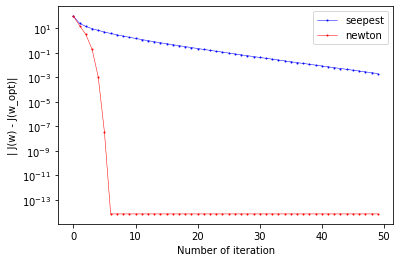

In [6]:
base = min(min(loss_sgm_history), min(loss_ntn_history))

show_itr = 50

plt.plot(np.abs(loss_sgm_history[:show_itr] - base), "bo-", linewidth=0.5, markersize=1, label='seepest')
plt.plot(np.abs(loss_ntn_history[:show_itr] - base), "ro-", linewidth=0.5, markersize=1, label='newton')
plt.legend()
plt.yscale("log")
plt.xlabel("Number of iteration")
plt.ylabel("| J(w) - J(w_opt)|")

## Logistic Regression for multi classification 

In [7]:
#------------#
# Dataset IV #
#------------#

d = 4
n = 200
x_d4 = 3*(np.random.rand(n, d) - 0.5)
y_d4 = (2*x_d4[:, 0] - 1*x_d4[:,1] + 0.5 + 0.5*np.random.randn(n)) > 0
y_d4 = 1*y_d4 # True: 1, False: 0

# shaping data
x_d4 = np.hstack([x_d4, np.ones((n, 1))])

print(x_d4.shape)
print(y_d4.shape)

(200, 5)
(200,)


In [8]:
#------------------------------------------------------------#
# functions for logistic regression for multi classification #
#------------------------------------------------------------#

def convert_to_oneshot(n, a):
    return np.identity(n, dtype=np.int)[a]

def soft_max(z):
    c     = np.max(z)
    e     = np.exp(z - c)
    e_sum = np.sum(e, axis=1).reshape(n, -1)

    return e/e_sum

In [9]:
n_class = 2

y_d4 = convert_to_oneshot(n_class, y_d4)

print(y_d4.shape)

itr = 200

(200, 2)


## Steepest gradient method for multiclass ver. of logistic regression

In [10]:
w = np.zeros((d+1, n_class))

loss_sgm_multi_history = []
loss = 0.

la, v = np.linalg.eigh(np.dot(x_d4.T, x_d4))
L = np.max(la) # lipschitz constant

for t in range(1, itr+1):
    f = soft_max(np.dot(x_d4, w))
    grad = -np.dot(x_d4.T, y_d4-f)
    
    loss = -np.sum((y_d4*np.log(f + 1e-10)))
    loss_sgm_multi_history.append(np.float64(loss))

    w = w - 1/L*grad

## Newton method for multiclass ver. of logistic regression

In [11]:
w = np.ones((d+1, n_class))

loss_ntn_multi_history = []
loss = 0.

for t in range(1, itr+1):
    f = soft_max(np.dot(x_d4, w))
    grad = -np.dot(x_d4.T, y_d4-f)
    
    # calc. hessian matrix
    hess  = np.zeros((n_class**2, d+1, d+1))
    delta = np.eye(n_class)
    for j in range(n_class):
        for k in range(n_class):
            delta = 1 if j == k else 0
            R = np.diag(f[:,k]*(delta - f[:,j]))
            hess[k + j*n_class] = np.dot(x_d4.T, np.dot(R, x_d4))

    loss = -np.sum(y_d4*np.log(f + 1e-10))
    loss_ntn_multi_history.append(np.float64(loss))

    for i in range(n_class):
        w = w - 0.5/np.sqrt(t)*np.dot(np.linalg.inv(hess[i + n_class*i]), grad)

## 4. Comparison of the two methods

Text(0, 0.5, '| J(w) - J(w_opt)|')

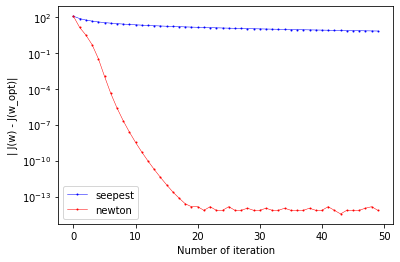

In [12]:
base = min(min(loss_sgm_multi_history), min(loss_ntn_multi_history))

show_itr = 50

plt.plot(np.abs(loss_sgm_multi_history[:show_itr] - base), "bo-", linewidth=0.5, markersize=1, label='seepest')
plt.plot(np.abs(loss_ntn_multi_history[:show_itr] - base), "ro-", linewidth=0.5, markersize=1, label='newton')
plt.legend()
plt.yscale("log")
plt.xlabel("Number of iteration")
plt.ylabel("| J(w) - J(w_opt)|")